# Boston House Price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#import csv
bhp_df = pd.read_csv('../assets/data/Boston_housing.csv')
bhp_df.head(5)

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2

In [8]:
bhp_df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [10]:
#drop null value
nbhp_df = bhp_df.dropna()
nbhp_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

<AxesSubplot:>

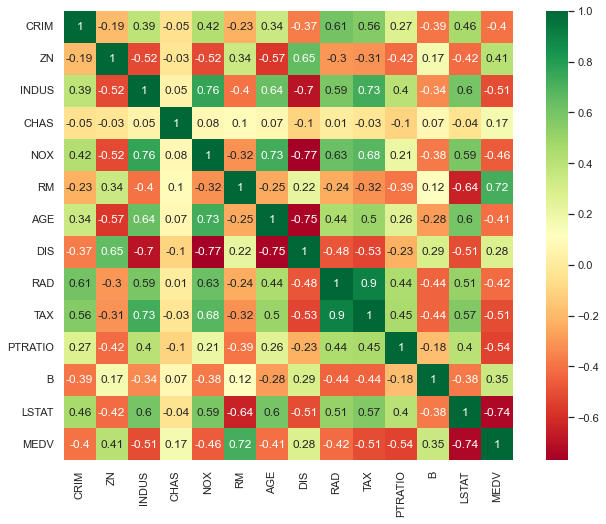

In [12]:
# set the size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(nbhp_df.corr().round(2), square=True, cmap='RdYlGn', annot=True)

In [78]:
def get_feature_corr_filter(df, label, evaluate):
    corr = df.corr()
    features = []
    for col in df.columns:
        if evaluate(corr[col][label]) and col != label:
            features.append(col)
    return features

In [179]:
#import model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def train_and_predict(x_train, x_test, y_train, y_test):
    model = LinearRegression()
    model.fit(x_train, y_train)
    return model.predict(x_test)

def train_linear(df, feature, label):
    X = df[feature]
    Y = df[label]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    model = LinearRegression()
    model.fit(x_train, y_train)
    return model, y_test, model.predict(x_test)

def get_rmse(test, pred):
    return np.sqrt(metrics.mean_squared_error(test, pred))

def travel(item, candidate, i, evaluate):
    if len(item) == i:
        evaluate(candidate)
        return
    candidate.append(item[i])
    travel(item, candidate, i + 1, evaluate)
    candidate.pop()
    travel(item, candidate, i + 1, evaluate)

In [270]:
label = 'MEDV'
#get_feature_corr_filter(nbhp_df, label, lambda v: abs(v) >= 0)
features = ['INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']

model, y_test, pred = train_linear(nbhp_df, features, label)

get_rmse(y_test, pred)

4.888635917682772

Text(0, 0.5, 'Predicted Y')

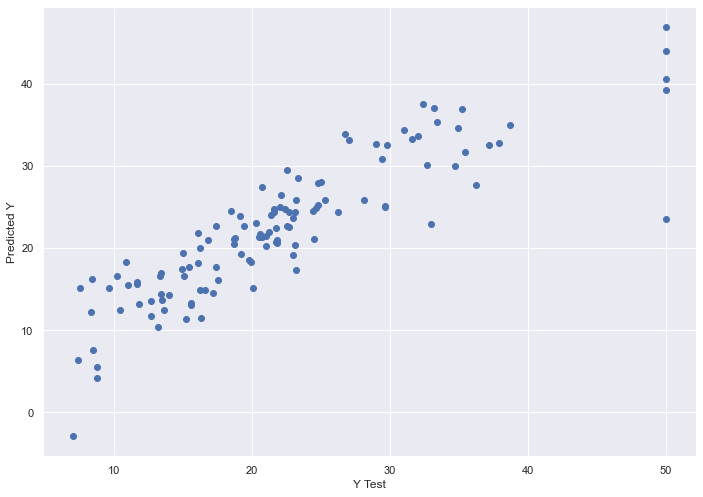

In [182]:
plt.scatter(y_test, pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [183]:
print("MAE", metrics.mean_absolute_error(y_test, pred))
print("MSE", metrics.mean_squared_error(y_test, pred))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE 3.362675839603811
MSE 21.373103292791892
RMSE 4.623105373316933


/Users/byungjin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


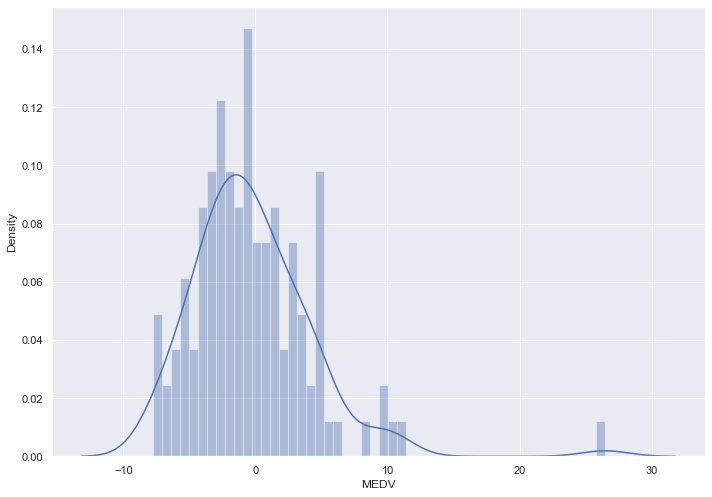

In [184]:
sns.distplot((y_test-pred),bins=50);

In [250]:
import copy

class SubsetTraveler:
    def __init__(self, candidate, condition, data = {}):
        self.candidate = candidate
        self.length = len(candidate)
        self.condition = condition
        self.result = []
        self.data = data
    def trip(self, item = [], i = 0):
        if self.length == i:
            self.evaluate(copy.deepcopy(item))
            return
        item.append(self.candidate[i])
        self.trip(item, i + 1)
        item.pop()
        self.trip(item, i + 1)
    def evaluate(self, subset):
        if(self.condition(self.data, subset)):
            self.result.append(subset)
        else:
            del subset
    def get_result(self):
        return self.result
    def get_data(self):
        return self.data

In [286]:
def df_condition(data, subset):
    if len(subset) == 0: return False
    
    global nbhp_df
    
    model, test, pred = train_linear(nbhp_df, subset, 'MEDV')
    
    rmse = get_rmse(test, pred)
    
    if data['rmse'] > rmse:
        data['rmse'] = rmse
        data['subset'] = subset
        data['pred'] = pred
        data['test'] = test

    if rmse <= 4.5:
        return True
    return False

In [299]:
data = {'rmse' : 10, 'subset' : [], 'pred' : [], 'test' : []}

traveler = SubsetTraveler(nbhp_df.drop('MEDV', axis=1).columns, df_condition, data)

traveler.trip()

traveler.get_data()

{'rmse': 3.201013570868014,
 'subset': ['ZN', 'INDUS', 'RM', 'DIS', 'RAD', 'B', 'LSTAT'],
 'pred': array([32.2829909 , 29.85535995, 32.03109015, 19.95339882, 20.60000119,
        35.47391639, 19.37607125, 27.94462001,  9.77728732, 20.95041672,
        18.34022464, 26.05039356, 20.02620969, 19.87680253, 17.37560921,
        22.39088356, 34.2136382 , 19.94612049, 23.68713208, 26.00081465,
        24.61658077, 23.1844542 , 24.55376597, 22.93187651, 11.67376101,
        17.64505648, 15.6845555 , 18.77668311, 22.33028328, 38.50522632,
        20.44334526, 34.68962647, 15.10158887, 30.85333663, 19.11311694,
        23.90530002, 26.59963672, 20.4458282 , 29.39328247, 16.4341708 ,
        32.16371039, 37.31656362, 23.286047  , 25.8586422 , 31.70557223,
        14.09373856, 29.08542049, 20.07406569, 19.09966089,  6.7244293 ,
        15.18987474, 24.93830863, 23.70075887, 23.59424059, 20.85403401,
        18.69946863, 16.15543975, 33.68763682, 28.31171209, 14.712282  ,
        33.00733694,  6.65

In [296]:
print(len(traveler.result))

i = 0

for subset in traveler.result:
    ev = list()
    for _ in range(50):
        model, y_test, pred = train_linear(nbhp_df, subset, 'MEDV')
        ev.append(get_rmse(y_test, pred))
    print(i, "\tmin - ", min(ev), "\tmax - ", max(ev) , "\tavg - ", np.mean(ev))
    i += 1

126
0 	min -  3.894274836134389 	max -  6.044820895038994 	avg -  4.933889169349197
1 	min -  3.927807362817274 	max -  6.212471219395391 	avg -  5.099323733636796
2 	min -  4.311494068085582 	max -  6.5788193760336755 	avg -  5.114432283193748
3 	min -  4.090475946300065 	max -  6.551255925580276 	avg -  5.096274544071342
4 	min -  4.051476648046477 	max -  6.536842200662359 	avg -  5.066102295731824
5 	min -  3.9997774642923667 	max -  6.806818622318163 	avg -  5.426559093341641
6 	min -  3.9792545137033946 	max -  5.852392764823526 	avg -  4.936075326300703
7 	min -  4.0525432338284135 	max -  7.69986107860924 	avg -  5.630400421169384
8 	min -  4.368888592752034 	max -  6.120293894095161 	avg -  5.311300719597007
9 	min -  4.226344219346052 	max -  6.865520369312839 	avg -  5.279617919501151
10 	min -  3.78612034772556 	max -  6.589068067062183 	avg -  5.107386366483674
11 	min -  4.32469590684599 	max -  6.145783509638583 	avg -  5.2785872364440145
12 	min -  3.924061556382369 	ma

102 	min -  3.9490496463884157 	max -  6.408367153763292 	avg -  5.103096227331724
103 	min -  3.740047204777183 	max -  6.641021583441717 	avg -  5.168975253691772
104 	min -  3.819182090001408 	max -  6.522418426841095 	avg -  4.891400937299828
105 	min -  4.2240537610101825 	max -  7.335785794561983 	avg -  5.536657590262084
106 	min -  4.40390071060724 	max -  6.790259893607299 	avg -  5.289063817539402
107 	min -  3.758524566729578 	max -  6.6721905557441366 	avg -  5.052558652164252
108 	min -  3.910200188068467 	max -  6.872529546651457 	avg -  5.182395762431722
109 	min -  3.570071445059045 	max -  6.0726501446387005 	avg -  4.889342636669752
110 	min -  4.136332084983689 	max -  6.3188806824022725 	avg -  5.1032661803191415
111 	min -  3.9158743333216517 	max -  6.610520971796582 	avg -  5.002330736379985
112 	min -  4.369783478397758 	max -  7.879327986917187 	avg -  5.71186009838613
113 	min -  3.97365165185348 	max -  6.382193653823911 	avg -  4.978810946209112
114 	min -  

In [ ]:
from BorutaShap import BorutaShap
